This code uses the entire 49-protein dataset to compare 10, 50, 100, 200, and 500 estimators in XGBoost. It incorporates 5-fold k-fold cross-validation 
Tried various combinations (all groups [blood cancers combined], all groups [blood cancers combined] except control, and pan-cancer only [blood cancers combined]). This code does not include bootstrapping

In [1]:
import pandas as pd

In [2]:
# Import the data

df_full = pd.read_csv("/Users/parinazfathi/Documents/GitHub/ErdosFall2024ProteinProfiles/Combined_df2.csv")


In [3]:
# Combine all the blood cancers into one category
df_bloodcombined = df_full.copy(deep = True)
df_bloodcombined=df_bloodcombined.replace(to_replace = ['AML', 'CLL', 'LYMPH', 'MYEL'], value = 'BLOOD' )

In [4]:
# Verify that the groups were combined as expected
set(df_bloodcombined['Cancer'])

{'BLOOD',
 'BRC',
 'CRC',
 'CVX',
 'Ctrl',
 'ENDC',
 'ESO',
 'GLIOM',
 'HODG',
 'LUNGC',
 'OVC',
 'PRC'}

In [5]:
# Drop the control data set
#df_bloodcombined = df_bloodcombined[df_bloodcombined['Cancer'] != 'Ctrl']

In [6]:
# Drop the non-pancancer data

# Values to keep
values_to_keep = {'BLOOD',
 'BRC',
 'CRC',
 'CVX',
 'ENDC',
 'GLIOM',
 'LUNGC',
 'OVC',
 'PRC'}

# Filter the DataFrame
df_bloodcombined = df_bloodcombined[df_bloodcombined['Cancer'].isin(values_to_keep)]


In [7]:
set(df_bloodcombined['Cancer'])

{'BLOOD', 'BRC', 'CRC', 'CVX', 'ENDC', 'GLIOM', 'LUNGC', 'OVC', 'PRC'}

In [8]:
# Specify the protein list 
proteins=df_bloodcombined.columns[4:]
# Check that we have the right number of proteins
len(proteins)

49

In [9]:
df_bloodcombined.head()

,Unnamed: 0.1,Unnamed: 0,Sample_ID,Cancer,Q15389,P29965,P49763,Q02763,P01127,P09341,...,P09382,Q16790,P26842,P14210,P43489,O75144,O43927,P32970,Q8WXI7,P10144
261,261,0.0,AML_1,BLOOD,3.87015,5.34480,1.23705,0.85000,4.97385,4.69740,...,2.52640,-1.14620,1.09365,3.54535,1.81100,-0.44360,3.15170,1.46570,2.42120,2.76585
262,262,1.0,AML_10,BLOOD,0.23345,0.74840,1.30170,0.47620,0.83920,1.87625,...,0.76395,0.00320,0.94245,2.16410,1.89350,0.10625,0.30650,1.31625,0.31530,2.83840
263,263,2.0,AML_11,BLOOD,1.11750,3.25930,1.97380,0.61460,1.62395,2.24280,...,1.14435,-0.35315,1.38360,1.43085,1.07315,0.00470,0.44485,0.81220,-1.66810,-0.17985
264,264,3.0,AML_12,BLOOD,-1.28095,-0.34215,0.72035,0.76085,-3.21070,1.74255,...,NaN,-0.07265,1.09100,0.80565,1.36825,0.34380,1.09810,0.46845,-0.44885,0.28480
265,265,4.0,AML_13,BLOOD,1.89000,4.45310,1.65145,0.53765,3.51680,4.70935,...,2.33530,-0.09185,1.79415,2.86855,0.71435,-0.45920,3.80050,2.97715,-0.48200,3.46605


In [10]:
# Encode the cancer types as numbers

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_bloodcombined['Cancer'] = le.fit_transform(df_bloodcombined['Cancer'])

In [11]:
df_bloodcombined.head(15)

,Unnamed: 0.1,Unnamed: 0,Sample_ID,Cancer,Q15389,P29965,P49763,Q02763,P01127,P09341,...,P09382,Q16790,P26842,P14210,P43489,O75144,O43927,P32970,Q8WXI7,P10144
261,261,0.0,AML_1,0,3.87015,5.34480,1.23705,0.85000,4.97385,4.69740,...,2.52640,-1.14620,1.09365,3.54535,1.81100,-0.44360,3.15170,1.46570,2.42120,2.76585
262,262,1.0,AML_10,0,0.23345,0.74840,1.30170,0.47620,0.83920,1.87625,...,0.76395,0.00320,0.94245,2.16410,1.89350,0.10625,0.30650,1.31625,0.31530,2.83840
263,263,2.0,AML_11,0,1.11750,3.25930,1.97380,0.61460,1.62395,2.24280,...,1.14435,-0.35315,1.38360,1.43085,1.07315,0.00470,0.44485,0.81220,-1.66810,-0.17985
264,264,3.0,AML_12,0,-1.28095,-0.34215,0.72035,0.76085,-3.21070,1.74255,...,NaN,-0.07265,1.09100,0.80565,1.36825,0.34380,1.09810,0.46845,-0.44885,0.28480
265,265,4.0,AML_13,0,1.89000,4.45310,1.65145,0.53765,3.51680,4.70935,...,2.33530,-0.09185,1.79415,2.86855,0.71435,-0.45920,3.80050,2.97715,-0.48200,3.46605
266,266,5.0,AML_14,0,1.31915,1.84985,1.97145,1.29115,0.77720,3.25515,...,1.97760,1.15440,1.03710,3.00600,2.16895,1.23810,1.23730,0.80130,0.34115,1.89245
267,267,6.0,AML_15,0,0.75260,0.40805,1.17710,0.69010,-0.52645,1.69685,...,1.89015,-0.47500,1.43125,3.36700,1.45050,-0.51475,0.39570,1.83685,1.32780,3.92600
268,268,7.0,AML_16,0,-2.94370,-0.38530,2.19285,0.56625,-3.72715,1.25215,...,0.33845,-0.12315,1.86160,0.92555,1.94415,0.06235,0.40540,2.58480,1.10970,1.50860
269,269,8.0,AML_17,0,1.61740,2.99735,1.89325,0.27850,1.65395,3.72510,...,2.11670,0.80360,2.84105,1.51915,3.62975,NaN,5.10310,1.66190,NaN,2.20995
270,270,9.0,AML_18,0,-1.30810,-0.30770,2.69550,0.93140,-2.32635,1.43120,...,2.31245,1.35865,3.46490,2.12965,2.60485,0.39990,1.41015,5.16690,1.29280,1.26085


In [12]:
# Split the data into X and y
X = df_bloodcombined[proteins]
y = df_bloodcombined['Cancer']

In [13]:
X.head()

,Q15389,P29965,P49763,Q02763,P01127,P09341,O00182,Q14116,P09601,Q92583,...,P09382,Q16790,P26842,P14210,P43489,O75144,O43927,P32970,Q8WXI7,P10144
261,3.87015,5.34480,1.23705,0.85000,4.97385,4.69740,1.59230,1.08450,1.81695,2.04445,...,2.52640,-1.14620,1.09365,3.54535,1.81100,-0.44360,3.15170,1.46570,2.42120,2.76585
262,0.23345,0.74840,1.30170,0.47620,0.83920,1.87625,1.16670,0.04940,2.04610,0.83345,...,0.76395,0.00320,0.94245,2.16410,1.89350,0.10625,0.30650,1.31625,0.31530,2.83840
263,1.11750,3.25930,1.97380,0.61460,1.62395,2.24280,1.41675,0.16355,0.56255,0.38805,...,1.14435,-0.35315,1.38360,1.43085,1.07315,0.00470,0.44485,0.81220,-1.66810,-0.17985
264,-1.28095,-0.34215,0.72035,0.76085,-3.21070,1.74255,0.98105,0.03160,NaN,-0.62225,...,NaN,-0.07265,1.09100,0.80565,1.36825,0.34380,1.09810,0.46845,-0.44885,0.28480
265,1.89000,4.45310,1.65145,0.53765,3.51680,4.70935,2.13880,1.02810,3.33590,0.88205,...,2.33530,-0.09185,1.79415,2.86855,0.71435,-0.45920,3.80050,2.97715,-0.48200,3.46605


In [14]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, stratify = y, test_size=0.2, random_state=100)

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import resample
from sklearn.multiclass import OneVsRestClassifier
from scipy.stats import sem
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.metrics import geometric_mean_score  # G-Mean

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Initialize models
models = {
    #"Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='lbfgs')),
    #"k-Nearest Neighbors (n=5)": KNeighborsClassifier(n_neighbors=5), 
    #"k-Nearest Neighbors (n=13)": KNeighborsClassifier(n_neighbors=13),
    #"Random Forest": RandomForestClassifier(n_estimators=100, random_state=100),
    "XGBoost, 10 estimators": XGBClassifier(n_estimators=10),
    "XGBoost, 50 estimators": XGBClassifier(n_estimators=50),
    "XGBoost, 100 estimators": XGBClassifier(n_estimators=100),
    "XGBoost, 200 estimators": XGBClassifier(n_estimators=200),
    "XGBoost, 500 estimators": XGBClassifier(n_estimators=500)
}

In [17]:
# Cross-validation and bootstrapping parameters
n_splits = 5  # Number of folds
n_bootstraps = 1000  # Number of bootstraps for confidence interval calculation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)

In [18]:
# Initialize KNNImputer for handling missing values
imputer = KNNImputer(n_neighbors=5, weights="uniform")


Evaluating XGBoost, 10 estimators with k-fold CV and kNN imputation...


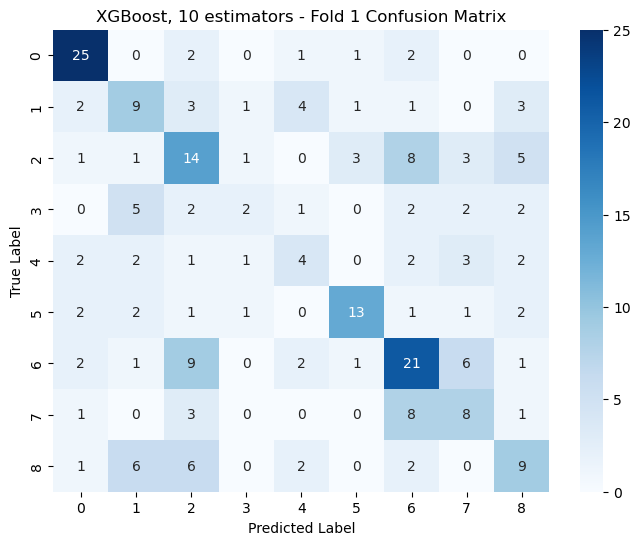


Fold 1 - Accuracy: 0.4430, F1 Score: 0.4358, ROC AUC: 0.8078, G-Mean: 0.6379


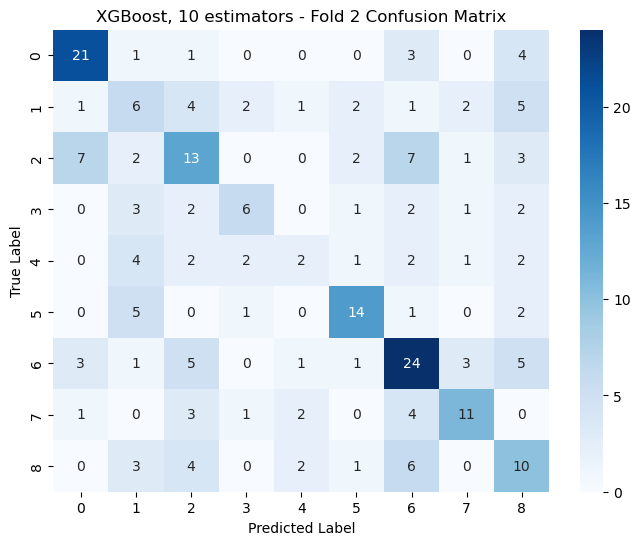


Fold 2 - Accuracy: 0.4534, F1 Score: 0.4487, ROC AUC: 0.8278, G-Mean: 0.6460


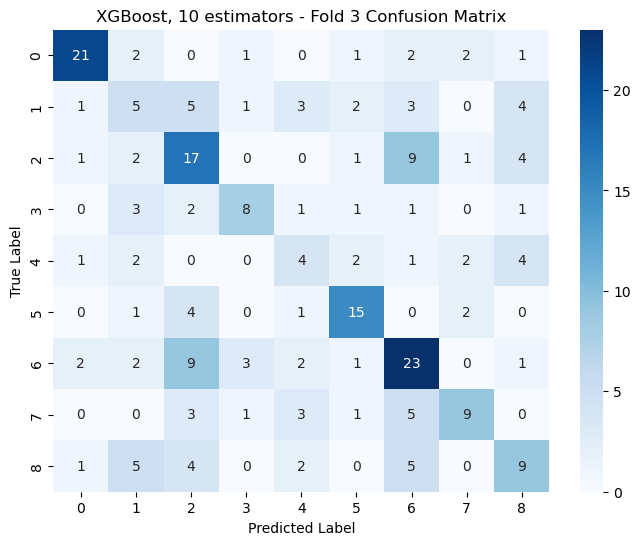


Fold 3 - Accuracy: 0.4703, F1 Score: 0.4709, ROC AUC: 0.8274, G-Mean: 0.6589


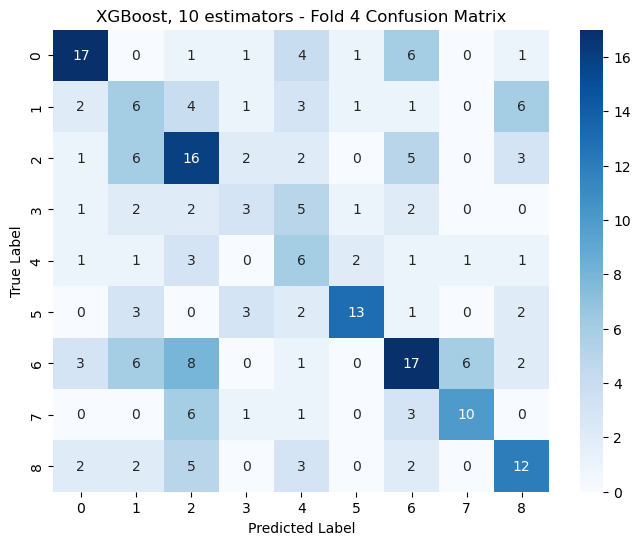


Fold 4 - Accuracy: 0.4237, F1 Score: 0.4309, ROC AUC: 0.8283, G-Mean: 0.6246


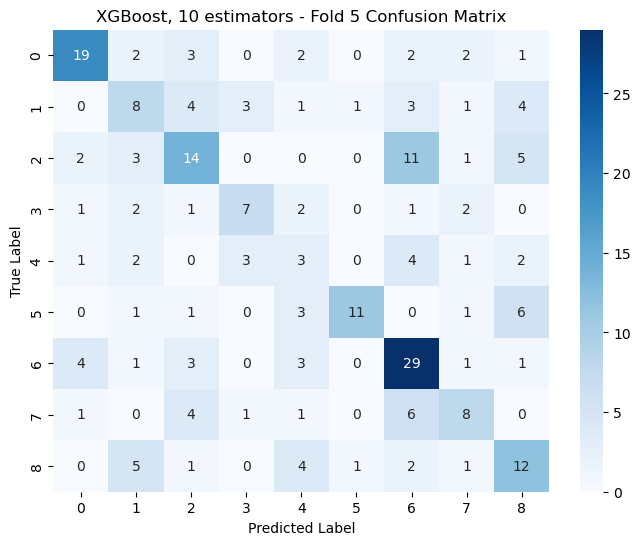


Fold 5 - Accuracy: 0.4703, F1 Score: 0.4719, ROC AUC: 0.8342, G-Mean: 0.6594

XGBoost, 10 estimators - Mean Accuracy: 0.4522 ± 0.0173
XGBoost, 10 estimators - Mean F1 Score: 0.4516 ± 0.0168
XGBoost, 10 estimators - Mean ROC AUC: 0.8251 ± 0.0088
XGBoost, 10 estimators - Mean G-Mean: 0.6454 ± 0.0129

Evaluating XGBoost, 50 estimators with k-fold CV and kNN imputation...


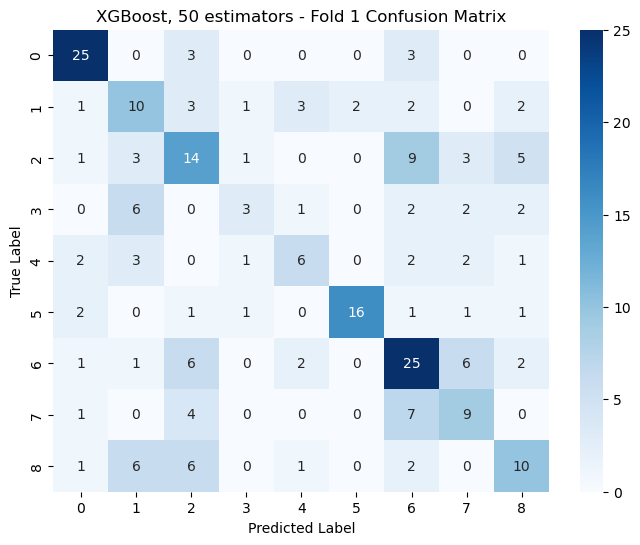


Fold 1 - Accuracy: 0.4979, F1 Score: 0.4947, ROC AUC: 0.8342, G-Mean: 0.6786


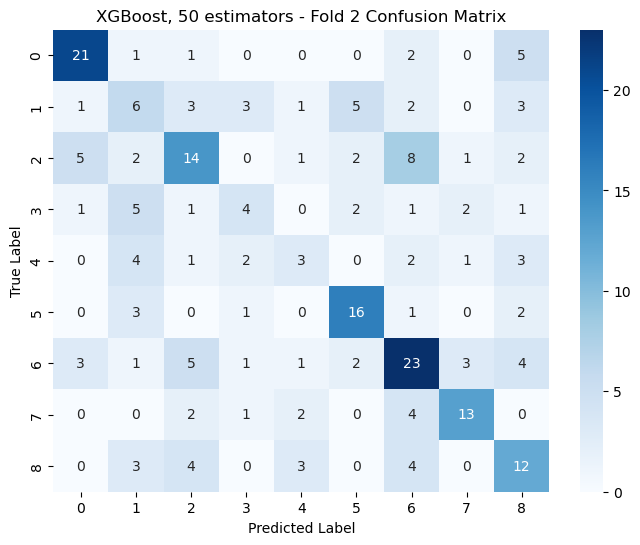


Fold 2 - Accuracy: 0.4746, F1 Score: 0.4691, ROC AUC: 0.8470, G-Mean: 0.6629


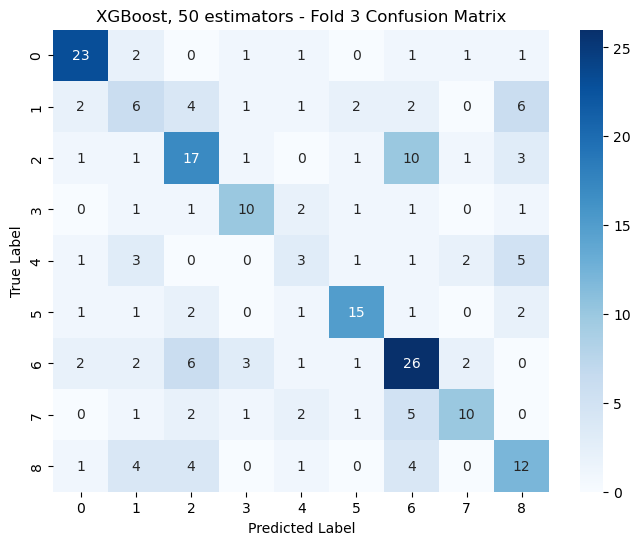


Fold 3 - Accuracy: 0.5169, F1 Score: 0.5129, ROC AUC: 0.8519, G-Mean: 0.6933


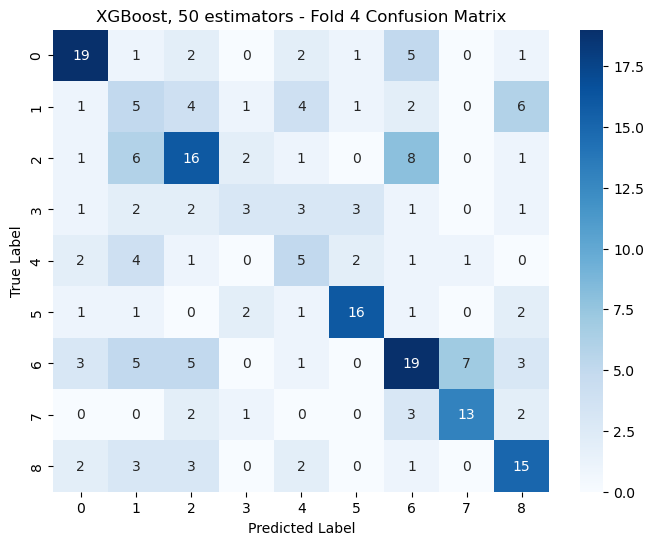


Fold 4 - Accuracy: 0.4703, F1 Score: 0.4699, ROC AUC: 0.8497, G-Mean: 0.6601


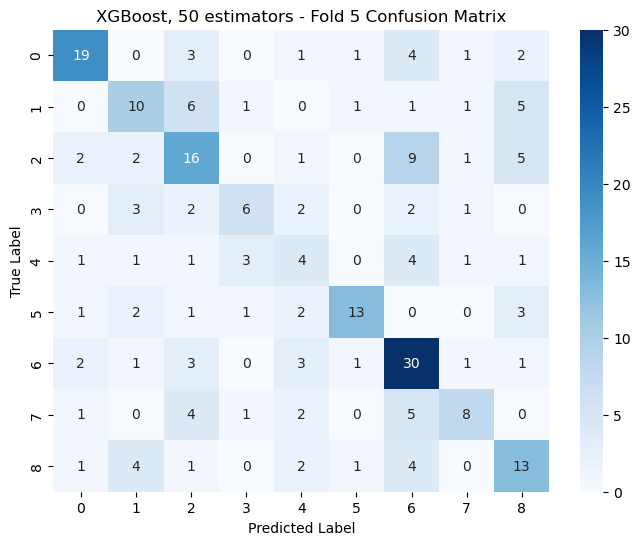


Fold 5 - Accuracy: 0.5042, F1 Score: 0.5035, ROC AUC: 0.8529, G-Mean: 0.6836

XGBoost, 50 estimators - Mean Accuracy: 0.4928 ± 0.0174
XGBoost, 50 estimators - Mean F1 Score: 0.4900 ± 0.0174
XGBoost, 50 estimators - Mean ROC AUC: 0.8472 ± 0.0066
XGBoost, 50 estimators - Mean G-Mean: 0.6757 ± 0.0123

Evaluating XGBoost, 100 estimators with k-fold CV and kNN imputation...


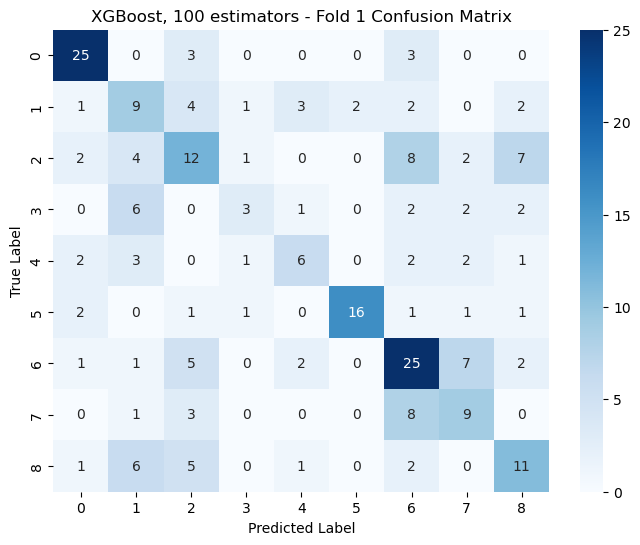


Fold 1 - Accuracy: 0.4895, F1 Score: 0.4864, ROC AUC: 0.8377, G-Mean: 0.6726


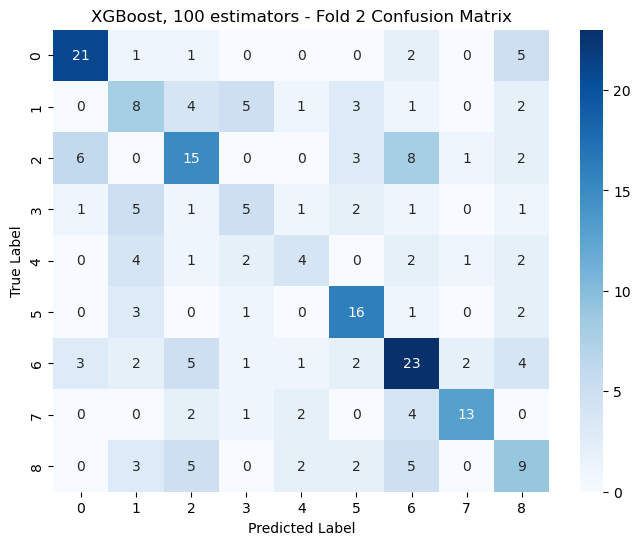


Fold 2 - Accuracy: 0.4831, F1 Score: 0.4810, ROC AUC: 0.8486, G-Mean: 0.6690


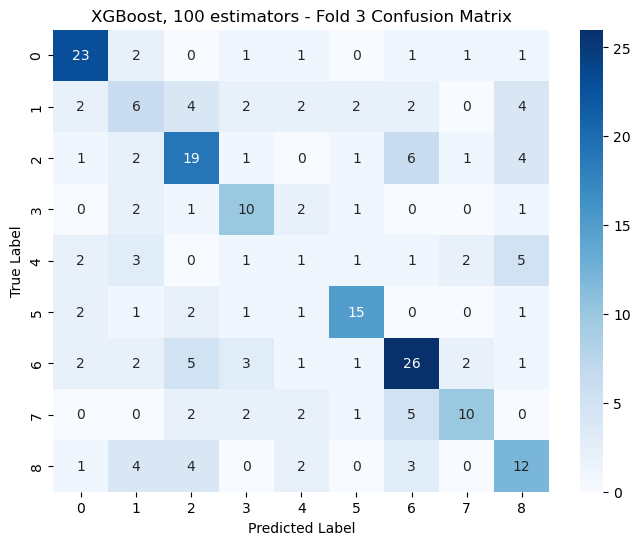


Fold 3 - Accuracy: 0.5169, F1 Score: 0.5114, ROC AUC: 0.8591, G-Mean: 0.6949


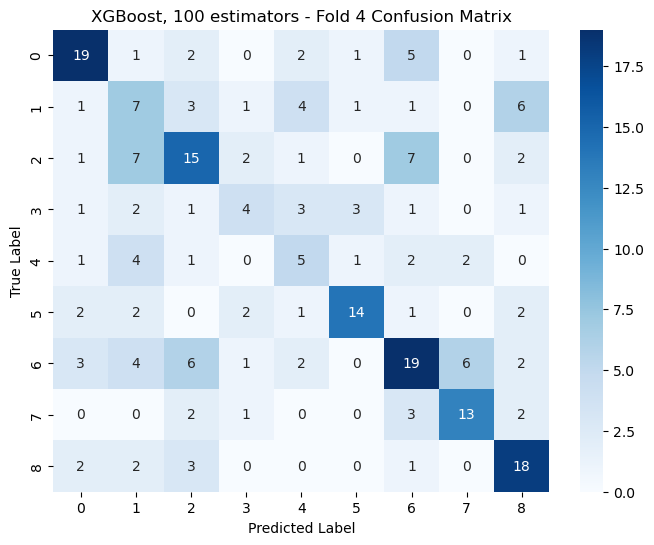


Fold 4 - Accuracy: 0.4831, F1 Score: 0.4835, ROC AUC: 0.8516, G-Mean: 0.6697


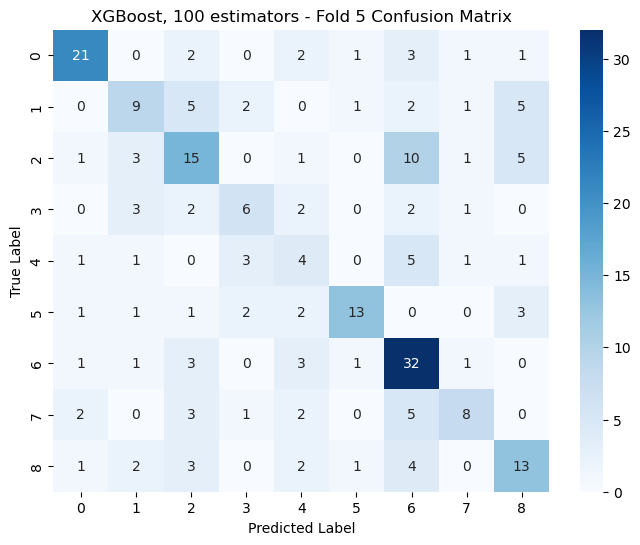


Fold 5 - Accuracy: 0.5127, F1 Score: 0.5099, ROC AUC: 0.8582, G-Mean: 0.6898

XGBoost, 100 estimators - Mean Accuracy: 0.4970 ± 0.0145
XGBoost, 100 estimators - Mean F1 Score: 0.4944 ± 0.0131
XGBoost, 100 estimators - Mean ROC AUC: 0.8510 ± 0.0076
XGBoost, 100 estimators - Mean G-Mean: 0.6792 ± 0.0107

Evaluating XGBoost, 200 estimators with k-fold CV and kNN imputation...


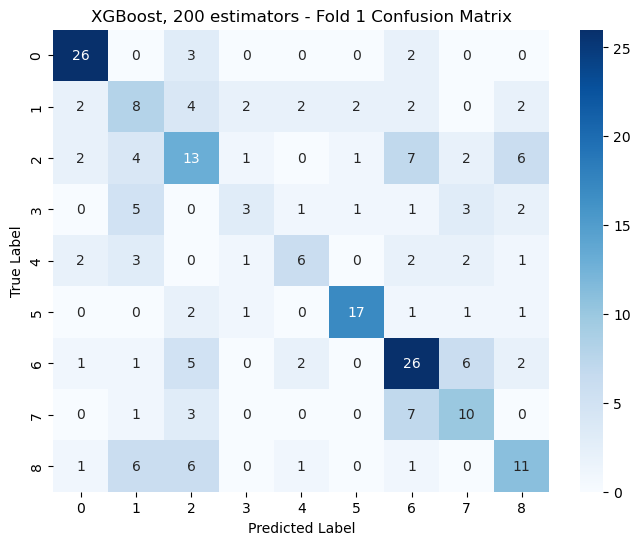


Fold 1 - Accuracy: 0.5063, F1 Score: 0.5015, ROC AUC: 0.8411, G-Mean: 0.6855


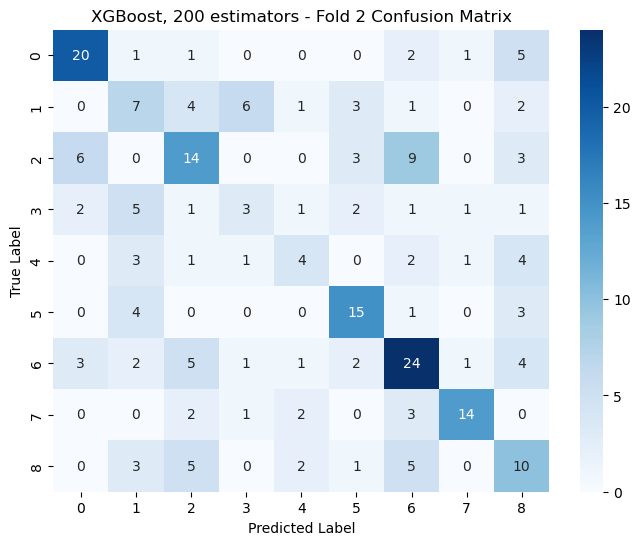


Fold 2 - Accuracy: 0.4703, F1 Score: 0.4675, ROC AUC: 0.8468, G-Mean: 0.6594


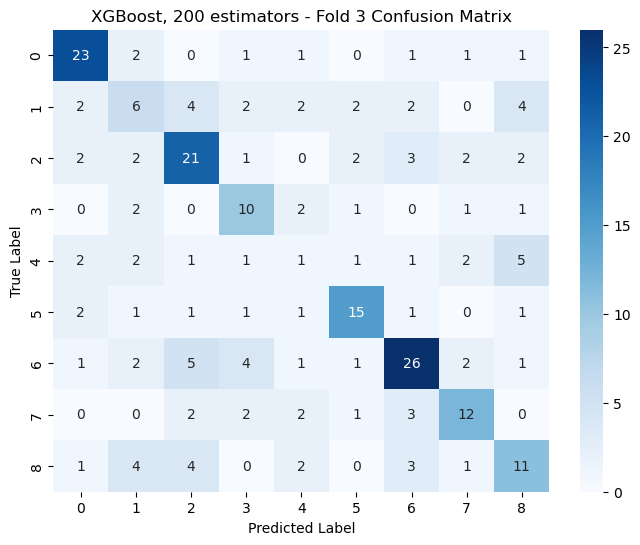


Fold 3 - Accuracy: 0.5297, F1 Score: 0.5234, ROC AUC: 0.8612, G-Mean: 0.7049


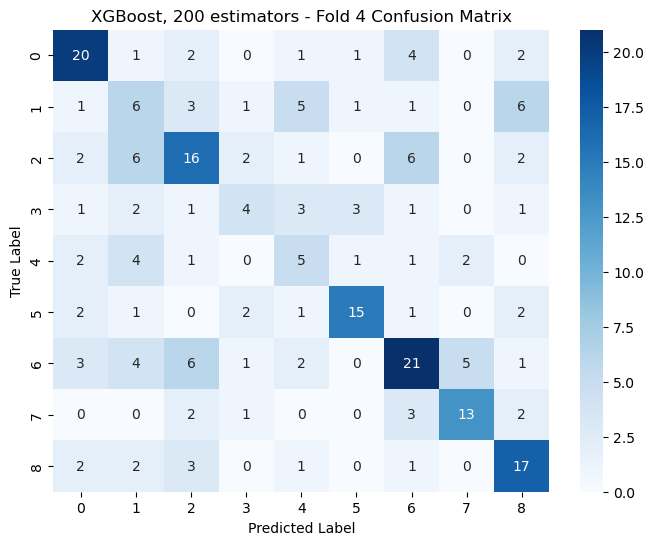


Fold 4 - Accuracy: 0.4958, F1 Score: 0.4958, ROC AUC: 0.8524, G-Mean: 0.6794


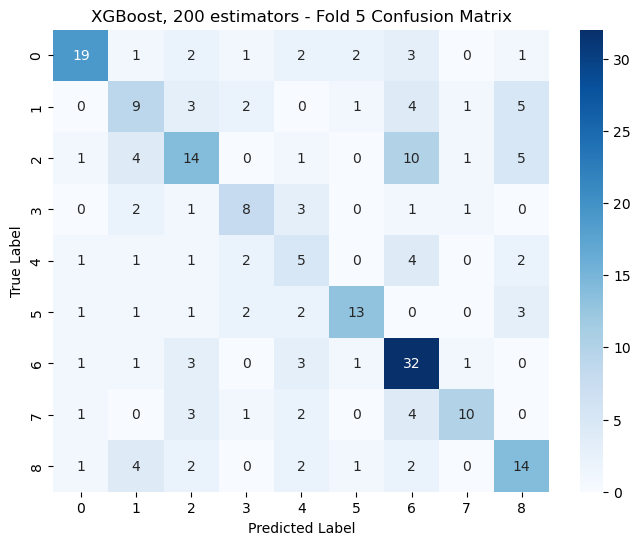


Fold 5 - Accuracy: 0.5254, F1 Score: 0.5257, ROC AUC: 0.8631, G-Mean: 0.6997

XGBoost, 200 estimators - Mean Accuracy: 0.5055 ± 0.0211
XGBoost, 200 estimators - Mean F1 Score: 0.5028 ± 0.0208
XGBoost, 200 estimators - Mean ROC AUC: 0.8529 ± 0.0082
XGBoost, 200 estimators - Mean G-Mean: 0.6858 ± 0.0158

Evaluating XGBoost, 500 estimators with k-fold CV and kNN imputation...


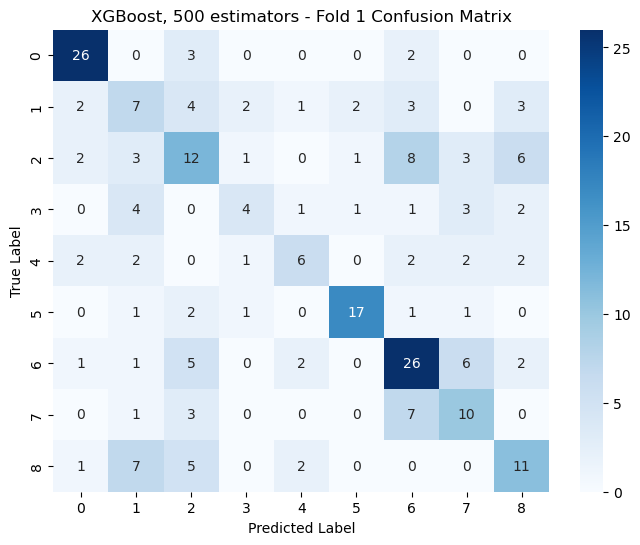


Fold 1 - Accuracy: 0.5021, F1 Score: 0.4977, ROC AUC: 0.8426, G-Mean: 0.6825


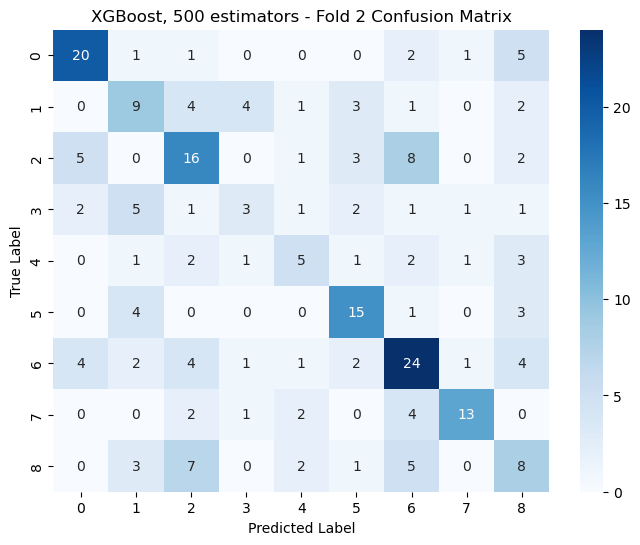


Fold 2 - Accuracy: 0.4788, F1 Score: 0.4754, ROC AUC: 0.8446, G-Mean: 0.6655


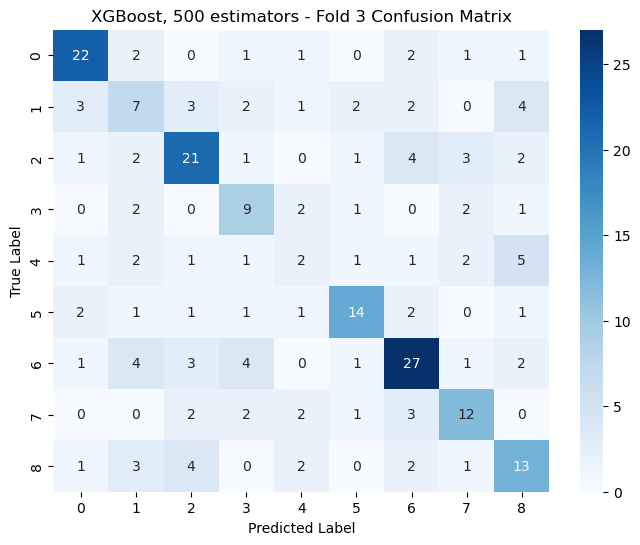


Fold 3 - Accuracy: 0.5381, F1 Score: 0.5345, ROC AUC: 0.8620, G-Mean: 0.7107


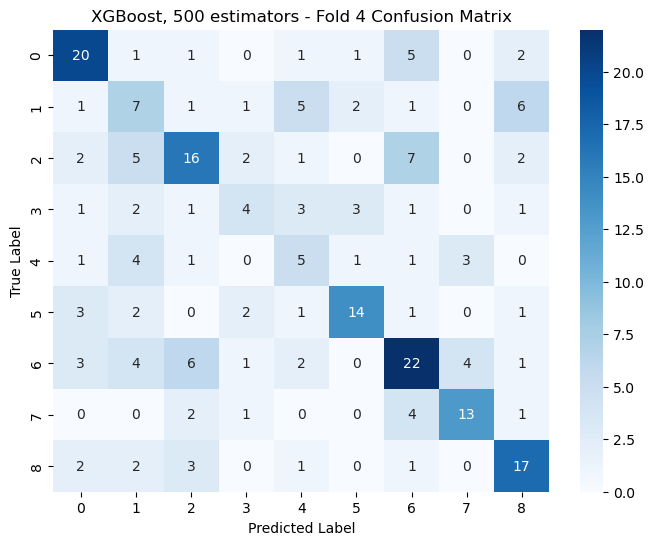


Fold 4 - Accuracy: 0.5000, F1 Score: 0.5000, ROC AUC: 0.8550, G-Mean: 0.6823


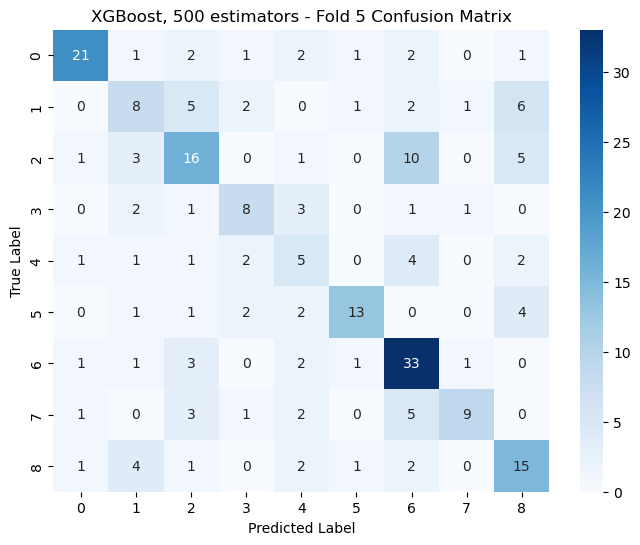


Fold 5 - Accuracy: 0.5424, F1 Score: 0.5418, ROC AUC: 0.8659, G-Mean: 0.7118

XGBoost, 500 estimators - Mean Accuracy: 0.5123 ± 0.0238
XGBoost, 500 estimators - Mean F1 Score: 0.5099 ± 0.0243
XGBoost, 500 estimators - Mean ROC AUC: 0.8540 ± 0.0090
XGBoost, 500 estimators - Mean G-Mean: 0.6906 ± 0.0176


In [19]:
# Loop over models
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} with k-fold CV and kNN imputation...")

    # Container for accuracy, F1, ROC AUC, G-Mean, and confusion matrices across folds
    fold_accuracies = []
    fold_f1_scores = []
    fold_auc_scores = []
    fold_gmeans = []
    fold_confusion_matrices = []

    # k-Fold Cross-Validation Loop
    for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        # Extract train and test sets for the current fold
        X_fold_train = X_train.iloc[train_index]
        X_fold_test = X_train.iloc[test_index]
        y_fold_train = y_train.iloc[train_index]
        y_fold_test = y_train.iloc[test_index]

        # Apply KNN Imputer to impute missing values
        X_fold_train_imputed = imputer.fit_transform(X_fold_train)
        X_fold_test_imputed = imputer.transform(X_fold_test)

        # Train the model on the imputed training data
        clf = model.fit(X_fold_train_imputed, y_fold_train)

        # Predict and evaluate metrics on the test fold
        y_pred = clf.predict(X_fold_test_imputed)
        fold_accuracy = accuracy_score(y_fold_test, y_pred)
        fold_f1 = f1_score(y_fold_test, y_pred, average='weighted')
        fold_gmean = geometric_mean_score(y_fold_test, y_pred, average='weighted')
        
        # ROC AUC requires probability estimates for each class
        y_proba = clf.predict_proba(X_fold_test_imputed)
        fold_auc = roc_auc_score(y_fold_test, y_proba, multi_class='ovr', average='weighted')

        # Append metrics for this fold
        fold_accuracies.append(fold_accuracy)
        fold_f1_scores.append(fold_f1)
        fold_auc_scores.append(fold_auc)
        fold_gmeans.append(fold_gmean)

        # Calculate and store confusion matrix for this fold
        fold_conf_matrix = confusion_matrix(y_fold_test, y_pred)
        fold_confusion_matrices.append(fold_conf_matrix)

        # Plot the confusion matrix as a heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(fold_conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f"{model_name} - Fold {i+1} Confusion Matrix")
        plt.show()

        # Print metrics for this fold
        print(f"\nFold {i+1} - Accuracy: {fold_accuracy:.4f}, F1 Score: {fold_f1:.4f}, "
              f"ROC AUC: {fold_auc:.4f}, G-Mean: {fold_gmean:.4f}")

    # Display averaged metrics with 95% confidence intervals
    mean_accuracy = np.mean(fold_accuracies)
    accuracy_confidence_interval = 1.96 * sem(fold_accuracies)

    mean_f1 = np.mean(fold_f1_scores)
    f1_confidence_interval = 1.96 * sem(fold_f1_scores)

    mean_auc = np.mean(fold_auc_scores)
    auc_confidence_interval = 1.96 * sem(fold_auc_scores)

    mean_gmean = np.mean(fold_gmeans)
    gmean_confidence_interval = 1.96 * sem(fold_gmeans)

    print(f"\n{model_name} - Mean Accuracy: {mean_accuracy:.4f} ± {accuracy_confidence_interval:.4f}")
    print(f"{model_name} - Mean F1 Score: {mean_f1:.4f} ± {f1_confidence_interval:.4f}")
    print(f"{model_name} - Mean ROC AUC: {mean_auc:.4f} ± {auc_confidence_interval:.4f}")
    print(f"{model_name} - Mean G-Mean: {mean_gmean:.4f} ± {gmean_confidence_interval:.4f}")
